<a href="https://colab.research.google.com/github/jeakwon/lpconv/blob/main/aRFbRFlpRF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [178]:
!git clone https://github.com/lfedros/Rossi-et-al-2020.git

fatal: destination path 'Rossi-et-al-2020' already exists and is not an empty directory.


In [179]:
!pip install allensdk

# Get artificial and biological RF

In [180]:
import cv2
import numpy as np
import torch
from allensdk.core.brain_observatory_cache import BrainObservatoryCache

def get_natural_scenes_data(image_size=(224, 224)):
    boc = BrainObservatoryCache()
    data_set = boc.get_ophys_experiment_data(501498760)
    scenes = data_set.get_stimulus_template('natural_scenes')
    numImages = scenes.shape[0]
    data = np.ndarray((numImages,1,image_size[0], image_size[1]))
    for n in range(0,numImages):
        thisImage = np.array(scenes[n,:,0:918])
        thisImage = cv2.resize(thisImage,image_size)
        thisImage = (thisImage - np.mean(thisImage))/np.std(thisImage)
        data[n,0,:,:] = thisImage
    data = torch.from_numpy( np.concatenate((data,data,data),axis=1) )
    return data

In [181]:
import os
import scipy.io
import torch
import numpy as np
import matplotlib.pyplot as plt
from torchvision.models import alexnet, convnext_tiny
from sklearn.preprocessing import StandardScaler

def convert_functional_synapses_to_receptive_field(xy_functional_synapses, bins=20, rf_ranges=[-4, 4]):
    """
    converts xy of functional_synapses into receptive fields
    as normalized zero-mean unit-variance standardized histograms
    """
    # get standardized xy of functional synapses
    scaler = StandardScaler()
    xy_standardized = scaler.fit_transform(xy_functional_synapses)

    x = xy_standardized[:, 0]
    y = xy_standardized[:, 1]

    histogram, xedges, yedges = np.histogram2d(x, y, bins=bins, range=[rf_ranges, rf_ranges])

    # get receptive field as normalized histogram
    receptive_field = histogram/histogram.sum()
    return receptive_field, xedges, yedges

def get_artificial_RF(bins, rf_ranges, sample_size=17, pretrained=True, inputs='images'):
    """
    get receptive field of functional synapses of AlexNet's first conv layer.
    :params bins: (int) number of bins for RF histogram
    :params rf_ranges: (list) histogram ranges. ex) [-4, 4]
    :params sample_size: (int) number of samples to use for model inputs. default 17 (max 118)
    :params pretrained: (bool) if True, use pretrained weights provided by torchvision
    :params inputs: (str) {'images'|'noises'}, either images (natural scenes dataset) or noises (random normal) can be used.
    """
    model=alexnet(pretrained=pretrained)

    conv_layer = model.features[0]
    conv_weights = conv_layer.weight.data
    bias = conv_layer.bias.data

    if inputs == 'images':
        batch_inputs = get_natural_scenes_data()[:sample_size]
    elif inputs == 'noises':
        batch_inputs = torch.randn(sample_size, 3, 224, 224)

    receptive_fields = []
    for n in range(sample_size):
        print(f'[{n+1}/{sample_size}] calculating RF')
        inputs = batch_inputs[n]
        num_channels, height, width = inputs.size()

        output_height = (height - conv_layer.kernel_size[0] + 2 * conv_layer.padding[0]) // conv_layer.stride[0] + 1
        output_width = (width - conv_layer.kernel_size[0] + 2 * conv_layer.padding[0]) // conv_layer.stride[0] + 1

        conv_output = torch.zeros(conv_weights.size(0), output_height, output_width)
        synaptic_activations = np.empty(shape = (conv_weights.size(0), output_height, output_width, conv_weights.size(2), conv_weights.size(3)) )

        std = synaptic_activations.std()
        for oc in range(conv_weights.size(0)):
            for ic in range(num_channels):
                for i in range(0, height - conv_layer.kernel_size[0] + 1, conv_layer.stride[0]):
                    for j in range(0, width - conv_layer.kernel_size[0] + 1, conv_layer.stride[0]):
                        receptive_field = inputs[ic, i:i + conv_layer.kernel_size[0], j:j + conv_layer.kernel_size[0]]
                        synaptic_activation = receptive_field * conv_weights[oc, ic]
                        synaptic_activations [oc, i // conv_layer.stride[0], j // conv_layer.stride[0], :,:] = synaptic_activation

                            # conv_output[b, oc, i // conv_layer.stride[0], j // conv_layer.stride[0]] += torch.sum(synaptic_activation)
        # conv_output += bias.view(1, -1, 1, 1)
        # conv_output_np = conv_output[0].cpu().detach().numpy()

        synaptic_activations = synaptic_activations.reshape(-1, conv_weights.size(2), conv_weights.size(3))
        activitiy_threshold = 2*synaptic_activations.std()

        all_syns = []
        for syn_activity in synaptic_activations:
            exc_activity =  syn_activity.clip(min=0)
            inh_activity = -syn_activity.clip(max=0)

            exc_syn = np.argwhere( exc_activity > activitiy_threshold )
            inh_syn = np.argwhere( inh_activity > activitiy_threshold )

            all_syns.append(exc_syn[:, :2])
            all_syns.append(inh_syn[:, :2])

        xy_functional_synapses = np.concatenate(all_syns)

        receptive_field, xedges, yedges = convert_functional_synapses_to_receptive_field(xy_functional_synapses, bins=bins)
        receptive_fields.append(receptive_field)
    receptive_fields = np.stack(receptive_fields)
    return receptive_fields, xedges, yedges

def get_biological_RF(bins, rf_ranges, sample_size=17, data_dir='/content/Rossi-et-al-2020/Data'):
    """
    get receptive field of functional synapses of mouse visual cortex V1 Layer2/3 neurons
    :params bins: (int) number of bins for RF histogram
    :params rf_ranges: (list) histogram ranges. ex) [-4, 4]
    :params sample_size: (int) number of samples to use for model inputs. default 17 (max 17)
    :params data_dir: (str) directory to synpase data
    """
    data = dict(
        postSyn = [],
        spatialEX = [],
        spatialIN = [],
        visualEX = [],
        visualIN = [],
    )

    for fpath in sorted(os.listdir(data_dir)):
        f = os.path.join(data_dir, fpath)
        mat_file = scipy.io.loadmat(f)
        name = fpath.split('_')[0]
        data[name].append(mat_file)


    receptive_fields = []
    for n in range(sample_size):
        print(f'[{n+1}/{sample_size}] calculating RF')
        all_syns = []
        exc_syn = data['spatialEX'][n]['spaceXYZ']-data['postSyn'][n]['spaceXYZ']
        inh_syn = data['spatialIN'][n]['spaceXYZ']-data['postSyn'][n]['spaceXYZ']

        all_syns.append(exc_syn[:, :2])
        all_syns.append(inh_syn[:, :2])

        xy_functional_synapses = np.concatenate(all_syns)

        receptive_field, xedges, yedges = convert_functional_synapses_to_receptive_field(xy_functional_synapses, bins=bins, rf_ranges=rf_ranges)
        receptive_fields.append(receptive_field)
    receptive_fields = np.stack(receptive_fields)
    return receptive_fields, xedges, yedges



In [182]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [17]:
rf_save_path = '/content/drive/MyDrive/lpconv/artificial_biological_rfs/RFs.pt'

bins, rf_ranges=19, [-4, 4]
RFs = dict(bins=bins,rf_ranges=rf_ranges)
bRFs, xedges, yedges = get_biological_RF(bins, rf_ranges);RFs['bRFs']=bRFs
RFs['xedges']=xedges
RFs['yedges']=yedges
torch.save(RFs, rf_save_path)
print('saved bRF')

RFs = torch.load(rf_save_path)
aRFs_nottrained_noises, xedges, yedges = get_artificial_RF(bins, rf_ranges, pretrained=False, inputs='noises', sample_size=17); RFs['aRFs_nottrained_noises']=aRFs_nottrained_noises
torch.save(RFs, rf_save_path)
print('saved aRFs_nottrained_noises')

RFs = torch.load(rf_save_path)
aRFs_nottrained_images, xedges, yedges = get_artificial_RF(bins, rf_ranges, pretrained=False, inputs='images', sample_size=17); RFs['aRFs_nottrained_images']=aRFs_nottrained_images
torch.save(RFs, rf_save_path)
print('saved aRFs_nottrained_images')

RFs = torch.load(rf_save_path)
aRFs_pretrained_noises, xedges, yedges = get_artificial_RF(bins, rf_ranges, pretrained=True,  inputs='noises', sample_size=17); RFs['aRFs_pretrained_noises']=aRFs_pretrained_noises
torch.save(RFs, rf_save_path)
print('saved aRFs_pretrained_noises')

RFs = torch.load(rf_save_path)
aRFs_pretrained_images, xedges, yedges = get_artificial_RF(bins, rf_ranges, pretrained=True,  inputs='images', sample_size=17); RFs['aRFs_pretrained_images']=aRFs_pretrained_images
torch.save(RFs, rf_save_path)
print('saved aRFs_pretrained_images')

[1/17] calculating RF
[2/17] calculating RF
[3/17] calculating RF
[4/17] calculating RF
[5/17] calculating RF
[6/17] calculating RF
[7/17] calculating RF
[8/17] calculating RF
[9/17] calculating RF
[10/17] calculating RF
[11/17] calculating RF
[12/17] calculating RF
[13/17] calculating RF
[14/17] calculating RF
[15/17] calculating RF
[16/17] calculating RF
[17/17] calculating RF
saved bRF


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


[1/17] calculating RF
[2/17] calculating RF
[3/17] calculating RF
[4/17] calculating RF
[5/17] calculating RF
[6/17] calculating RF
[7/17] calculating RF
[8/17] calculating RF
[9/17] calculating RF
[10/17] calculating RF
[11/17] calculating RF
[12/17] calculating RF
[13/17] calculating RF
[14/17] calculating RF
[15/17] calculating RF
[16/17] calculating RF
[17/17] calculating RF
saved aRFs_nottrained_noises


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
2023-09-07 07:42:51,292 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/well_known_file_download/514422179
INFO:allensdk.api.api.retrieve_file_over_http:Downloading URL: http://api.brain-map.org/api/v2/well_known_file_download/514422179


[1/17] calculating RF
[2/17] calculating RF
[3/17] calculating RF
[4/17] calculating RF
[5/17] calculating RF
[6/17] calculating RF
[7/17] calculating RF
[8/17] calculating RF
[9/17] calculating RF
[10/17] calculating RF
[11/17] calculating RF
[12/17] calculating RF
[13/17] calculating RF
[14/17] calculating RF
[15/17] calculating RF
[16/17] calculating RF
[17/17] calculating RF
saved aRFs_nottrained_images


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth
100%|██████████| 233M/233M [00:02<00:00, 96.5MB/s]


[1/17] calculating RF
[2/17] calculating RF
[3/17] calculating RF
[4/17] calculating RF
[5/17] calculating RF
[6/17] calculating RF
[7/17] calculating RF
[8/17] calculating RF
[9/17] calculating RF
[10/17] calculating RF
[11/17] calculating RF
[12/17] calculating RF
[13/17] calculating RF
[14/17] calculating RF
[15/17] calculating RF
[16/17] calculating RF
[17/17] calculating RF
saved aRFs_pretrained_noises


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


[1/17] calculating RF
[2/17] calculating RF
[3/17] calculating RF
[4/17] calculating RF
[5/17] calculating RF
[6/17] calculating RF
[7/17] calculating RF
[8/17] calculating RF
[9/17] calculating RF
[10/17] calculating RF
[11/17] calculating RF
[12/17] calculating RF
[13/17] calculating RF
[14/17] calculating RF
[15/17] calculating RF
[16/17] calculating RF
[17/17] calculating RF
saved aRFs_pretrained_images


In [183]:
import numpy as np
from numpy.linalg import det
import pandas as pd
from scipy.optimize import minimize
from scipy.special import gamma
import matplotlib.pyplot as plt
import seaborn as sns

def Phi(X, mu, C, p):
    # multivariate p-generalized normal distribution
    d, _ = X.shape
    K = ( 2 * gamma( 1 + p**-1 ) ** d * det(C) ) ** -1

    u = 0
    for i in range(d):

        v = 0
        for j in range(d):
            C_ij = C[i, j]
            X_j = X[j]
            mu_j = mu[j]

            v += C_ij*(X_j-mu_j)
        u += np.abs(v)**p
    return K*np.exp(-u)

def get_lpRF(offset, sigma=0.5, p=1):
    mu = np.array([0, 0])
    C = np.array([
        [1/sigma, 0],
        [0, 1/sigma]
    ])
    RF = Phi(offset.reshape(2, -1), mu, C, p=p).reshape(offset.shape[-2:])
    return RF/RF.sum()


def loss(params, offset, RF_target):
    sigma, p = params
    RF = get_lpRF(offset, sigma, p)
    return np.sum((RF - RF_target)**2)

def optimize_params(offset, RF_target):
    initial_guess = [0.5, 1]
    bounds = [(0.01, 2), (0.1, 256)]  # example bounds, can be adjusted
    result = minimize(loss, initial_guess, args=(offset, RF_target), bounds=bounds,)

    optimized_sigma, optimized_p = result.x
    return optimized_sigma, optimized_p

# Example usage:
offset = np.random.randn(2, 10, 10)  # just an example, use your actual offset data
Z_target = np.random.randn(10, 10)   # replace with your desired filter

optimized_sigma, optimized_p = optimize_params(offset, Z_target)
print("Optimized sigma:", optimized_sigma)
print("Optimized p:", optimized_p)

Optimized sigma: 0.4934193528077174
Optimized p: 5.821110542524375


<ipython-input-183-bc4afe9977b4>:34: RuntimeWarning: invalid value encountered in divide
  return RF/RF.sum()


In [284]:
x = (xedges[:-1]+xedges[1:])/2
y = (yedges[:-1]+yedges[1:])/2
offset = np.stack( np.meshgrid(x, y) )

df_data = []
for rf in RFs['bRFs']:
    Z_target = rf
    optimized_sigma, optimized_p = optimize_params(offset, Z_target)
    df_data.append( dict(key='bRFs', name='Mouse brain V1\nLayer 2/3', rf_type='biological', sigma=optimized_sigma, p=optimized_p) )

for rf in RFs['aRFs_pretrained_images']:
    Z_target = rf
    optimized_sigma, optimized_p = optimize_params(offset, Z_target)
    df_data.append( dict(key='aRFs_pretrained_images', name='AlexNet(trained)\nConv 1\n(+Image inputs)', rf_type='artificial', sigma=optimized_sigma, p=optimized_p, pretrained=True, inputs='images'))

for rf in RFs['aRFs_pretrained_noises']:
    Z_target = rf
    optimized_sigma, optimized_p = optimize_params(offset, Z_target)
    df_data.append( dict(key='aRFs_pretrained_noises', name='AlexNet(trained)\nConv 1\n(+Noise inputs)', rf_type='artificial', sigma=optimized_sigma, p=optimized_p, pretrained=True, inputs='noises'))

for rf in RFs['aRFs_nottrained_images']:
    Z_target = rf
    optimized_sigma, optimized_p = optimize_params(offset, Z_target)
    df_data.append( dict(key='aRFs_nottrained_images', name='AlexNet(untrained)\nConv 1\n(+Noise inputs)', rf_type='artificial', sigma=optimized_sigma, p=optimized_p, pretrained=False, inputs='noises'))

for rf in RFs['aRFs_nottrained_noises']:
    Z_target = rf
    optimized_sigma, optimized_p = optimize_params(offset, Z_target)
    df_data.append( dict(key='aRFs_nottrained_noises', name='AlexNet(untrained)\nConv 1\n(+Image inputs)', rf_type='artificial', sigma=optimized_sigma, p=optimized_p, pretrained=False, inputs='images'))

df = pd.DataFrame(df_data)
df.to_csv('/content/drive/MyDrive/lpconv/artificial_biological_rfs/optimization_result.csv')

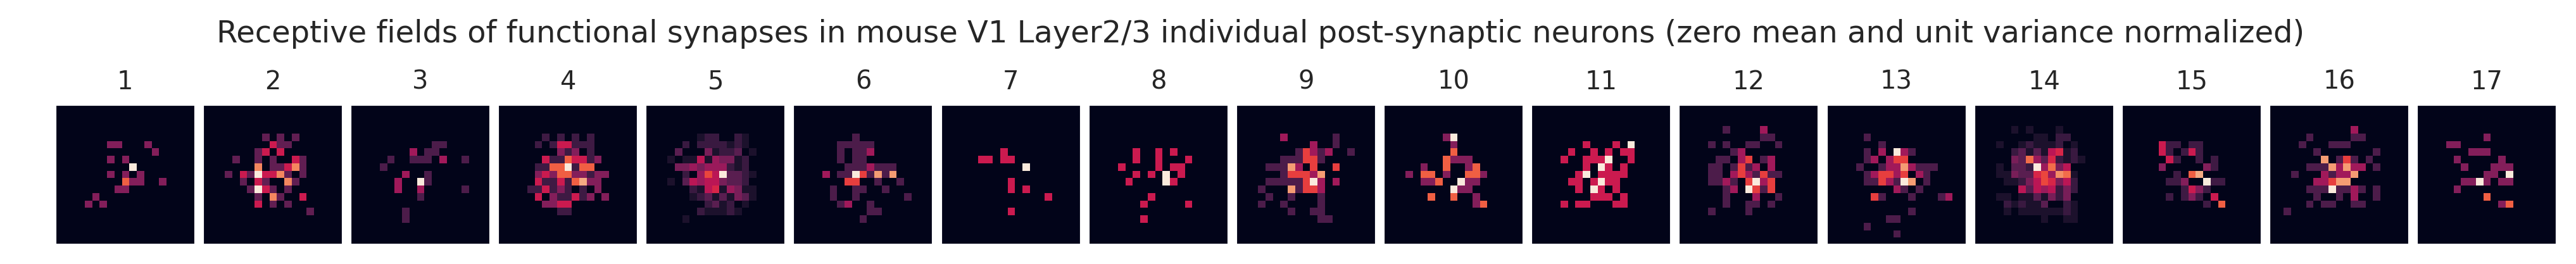

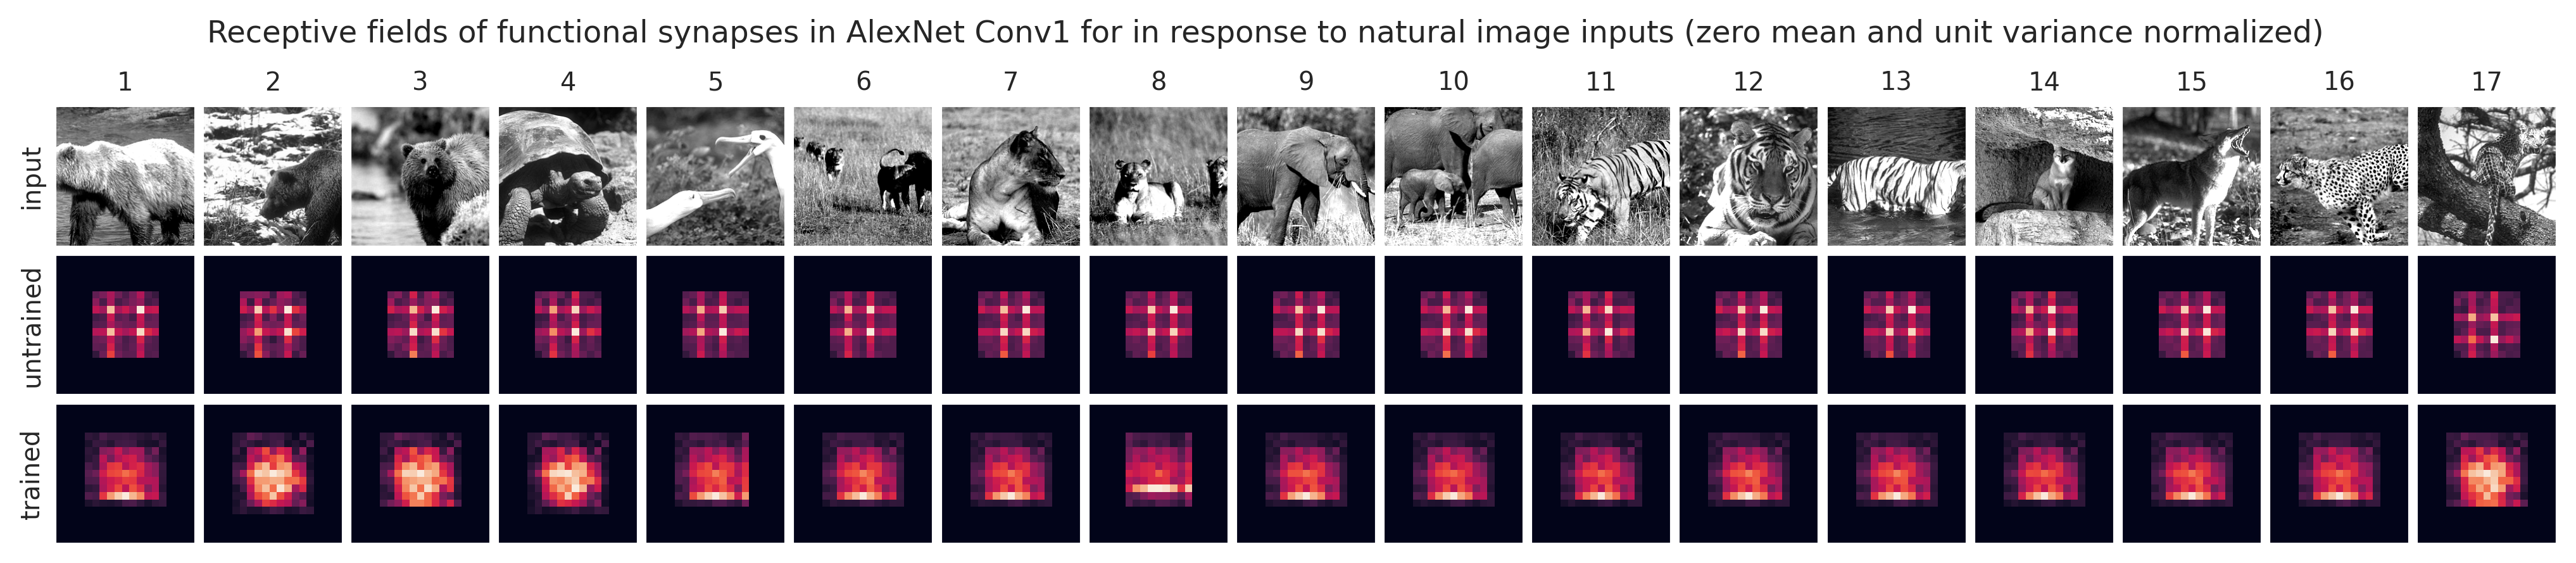

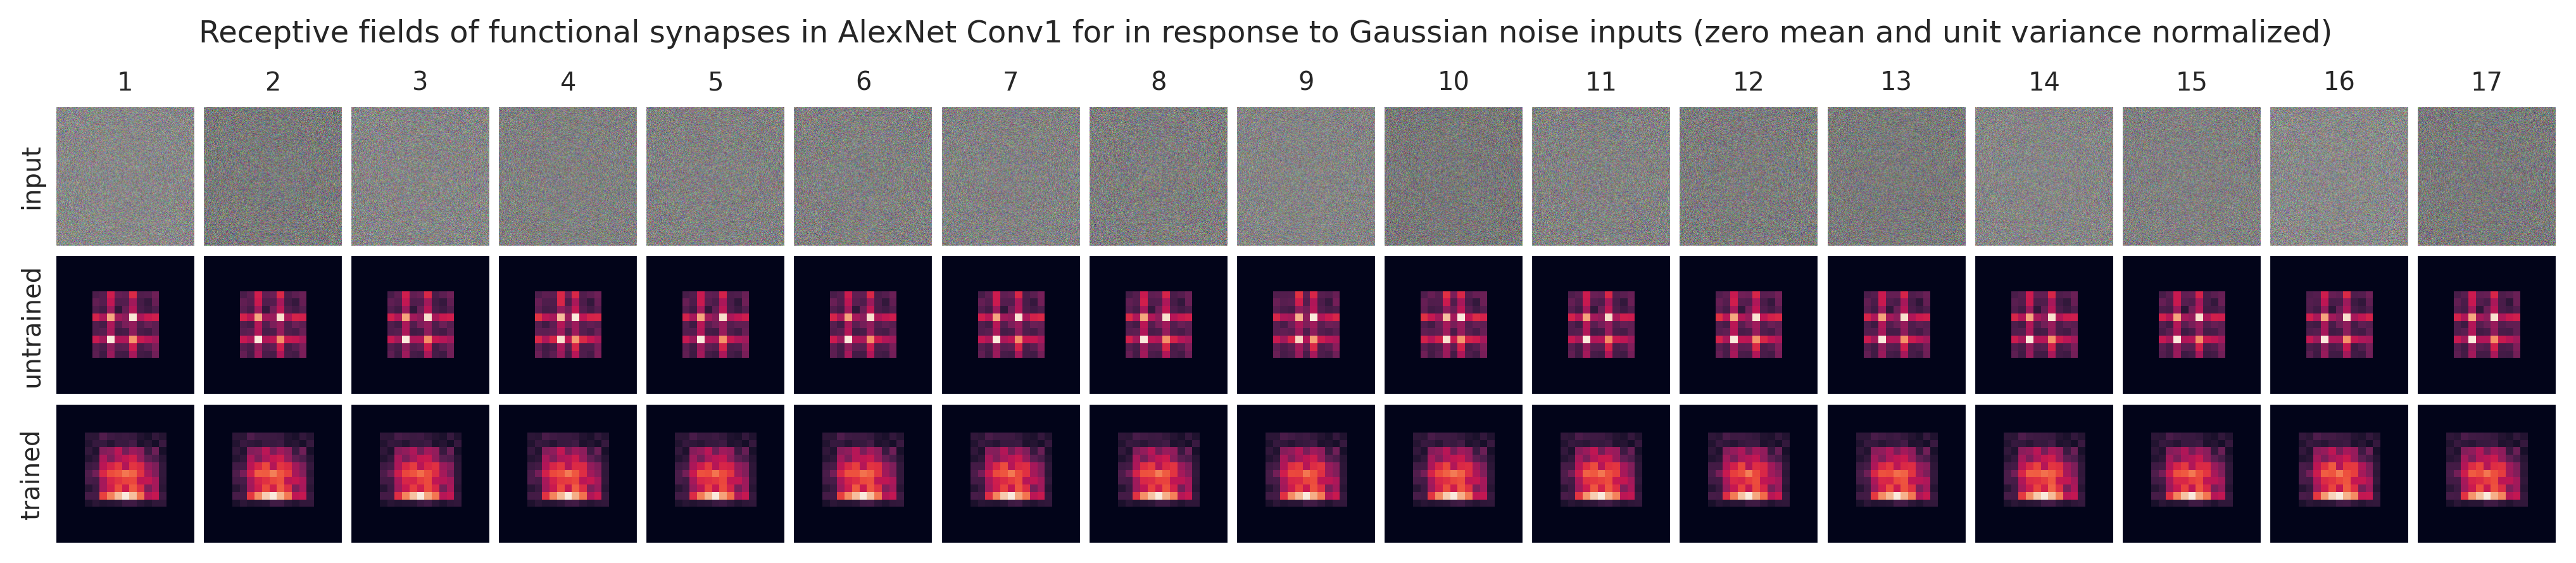

In [346]:
sns.set_style('dark')
fig, axes = plt.subplots(1, 17, figsize=(17, 1), dpi=300)
fig.subplots_adjust(wspace=0.05, hspace=0.05)
for i, rf in enumerate(RFs['bRFs']):
    ax = axes[i]
    ax.set_title(i+1)
    ax.imshow(rf)
for ax in axes.ravel():
    ax.set_xticks([])
    ax.set_yticks([])
    plt.suptitle('Receptive fields of functional synapses in mouse V1 Layer2/3 individual post-synaptic neurons (zero mean and unit variance normalized) \n', va='bottom')
axes[0].set_ylabel(' ')
fig.savefig('/content/drive/MyDrive/lpconv/artificial_biological_rfs/all_bRFs.png', bbox_inches='tight')
plt.show()

images = torch.load('/content/drive/MyDrive/lpconv/artificial_biological_rfs/images_n17.pt')
fig, axes = plt.subplots(3, 17, figsize=(17, 3), dpi=300)
fig.subplots_adjust(wspace=0.05, hspace=0.05)
for i in range(17):
    image = images[i]
    image = (image - image.min()) / (image.max() - image.min())
    axes[0, i].set_title(i+1)
    axes[0, i].imshow(image.permute(1, 2, 0))
    axes[1, i].imshow(RFs['aRFs_nottrained_images'][i])
    axes[2, i].imshow(RFs['aRFs_pretrained_images'][i])
for ax in axes.ravel():
    ax.set_xticks([])
    ax.set_yticks([])
axes[0, 0].set_ylabel('input')
axes[1, 0].set_ylabel('untrained')
axes[2, 0].set_ylabel('trained')
plt.suptitle('Receptive fields of functional synapses in AlexNet Conv1 for in response to natural image inputs (zero mean and unit variance normalized)', va='bottom')
fig.savefig('/content/drive/MyDrive/lpconv/artificial_biological_rfs/all_aRFs_image_inputs.png', bbox_inches='tight')
plt.show()

noises = torch.load('/content/drive/MyDrive/lpconv/artificial_biological_rfs/noises_n17.pt')
fig, axes = plt.subplots(3, 17, figsize=(17, 3), dpi=300)
fig.subplots_adjust(wspace=0.05, hspace=0.05)
for i in range(17):
    image = noises[i]
    image = (image - image.min()) / (image.max() - image.min())
    axes[0, i].set_title(i+1)
    axes[0, i].imshow(image.permute(1, 2, 0))
    axes[1, i].imshow(RFs['aRFs_nottrained_noises'][i])
    axes[2, i].imshow(RFs['aRFs_pretrained_noises'][i])
for ax in axes.ravel():
    ax.set_xticks([])
    ax.set_yticks([])
axes[0, 0].set_ylabel('input')
axes[1, 0].set_ylabel('untrained')
axes[2, 0].set_ylabel('trained')
plt.suptitle('Receptive fields of functional synapses in AlexNet Conv1 for in response to Gaussian noise inputs (zero mean and unit variance normalized)', va='bottom')
fig.savefig('/content/drive/MyDrive/lpconv/artificial_biological_rfs/all_aRFs_noise_inputs.png', bbox_inches='tight')
plt.show()

In [343]:
import pandas as pd
from scipy.stats import ttest_ind, mannwhitneyu
from itertools import combinations

tmp = df.melt(id_vars='name', value_vars='p')

results = []

for group1, group2 in combinations(tmp['name'].unique(), 2):
    values_group1 = tmp[tmp['name'] == group1]['value'].values
    values_group2 = tmp[tmp['name'] == group2]['value'].values

    # t_stat, p_value = ttest_ind(values_group1, values_group2, equal_var=False)
    u_stat, p_value = mannwhitneyu(values_group1, values_group2)
    significance = '***' if p_value<=0.001 else '**' if p_value<=0.01 else '*' if p_value<=0.05 else 'ns'
    results.append({
        'group1': group1,
        'group2': group2,
        # 't_stat': t_stat,
        'p_value': p_value,
        'significance': significance
    })

# Convert the results to a DataFrame for easier viewing
results_df = pd.DataFrame(results)
results_df.to_csv('/content/drive/MyDrive/lpconv/artificial_biological_rfs/summary_barplot_optimized_p_statistics.csv')
print(results_df)



                                        group1  \
0                    Mouse brain V1\nLayer 2/3   
1                    Mouse brain V1\nLayer 2/3   
2                    Mouse brain V1\nLayer 2/3   
3                    Mouse brain V1\nLayer 2/3   
4    AlexNet(trained)\nConv 1\n(+Image inputs)   
5    AlexNet(trained)\nConv 1\n(+Image inputs)   
6    AlexNet(trained)\nConv 1\n(+Image inputs)   
7    AlexNet(trained)\nConv 1\n(+Noise inputs)   
8    AlexNet(trained)\nConv 1\n(+Noise inputs)   
9  AlexNet(untrained)\nConv 1\n(+Noise inputs)   

                                        group2       p_value significance  
0    AlexNet(trained)\nConv 1\n(+Image inputs)  3.077325e-05          ***  
1    AlexNet(trained)\nConv 1\n(+Noise inputs)  1.218068e-05          ***  
2  AlexNet(untrained)\nConv 1\n(+Noise inputs)  7.054088e-07          ***  
3  AlexNet(untrained)\nConv 1\n(+Image inputs)  7.054088e-07          ***  
4    AlexNet(trained)\nConv 1\n(+Noise inputs)  2.415666e-01         

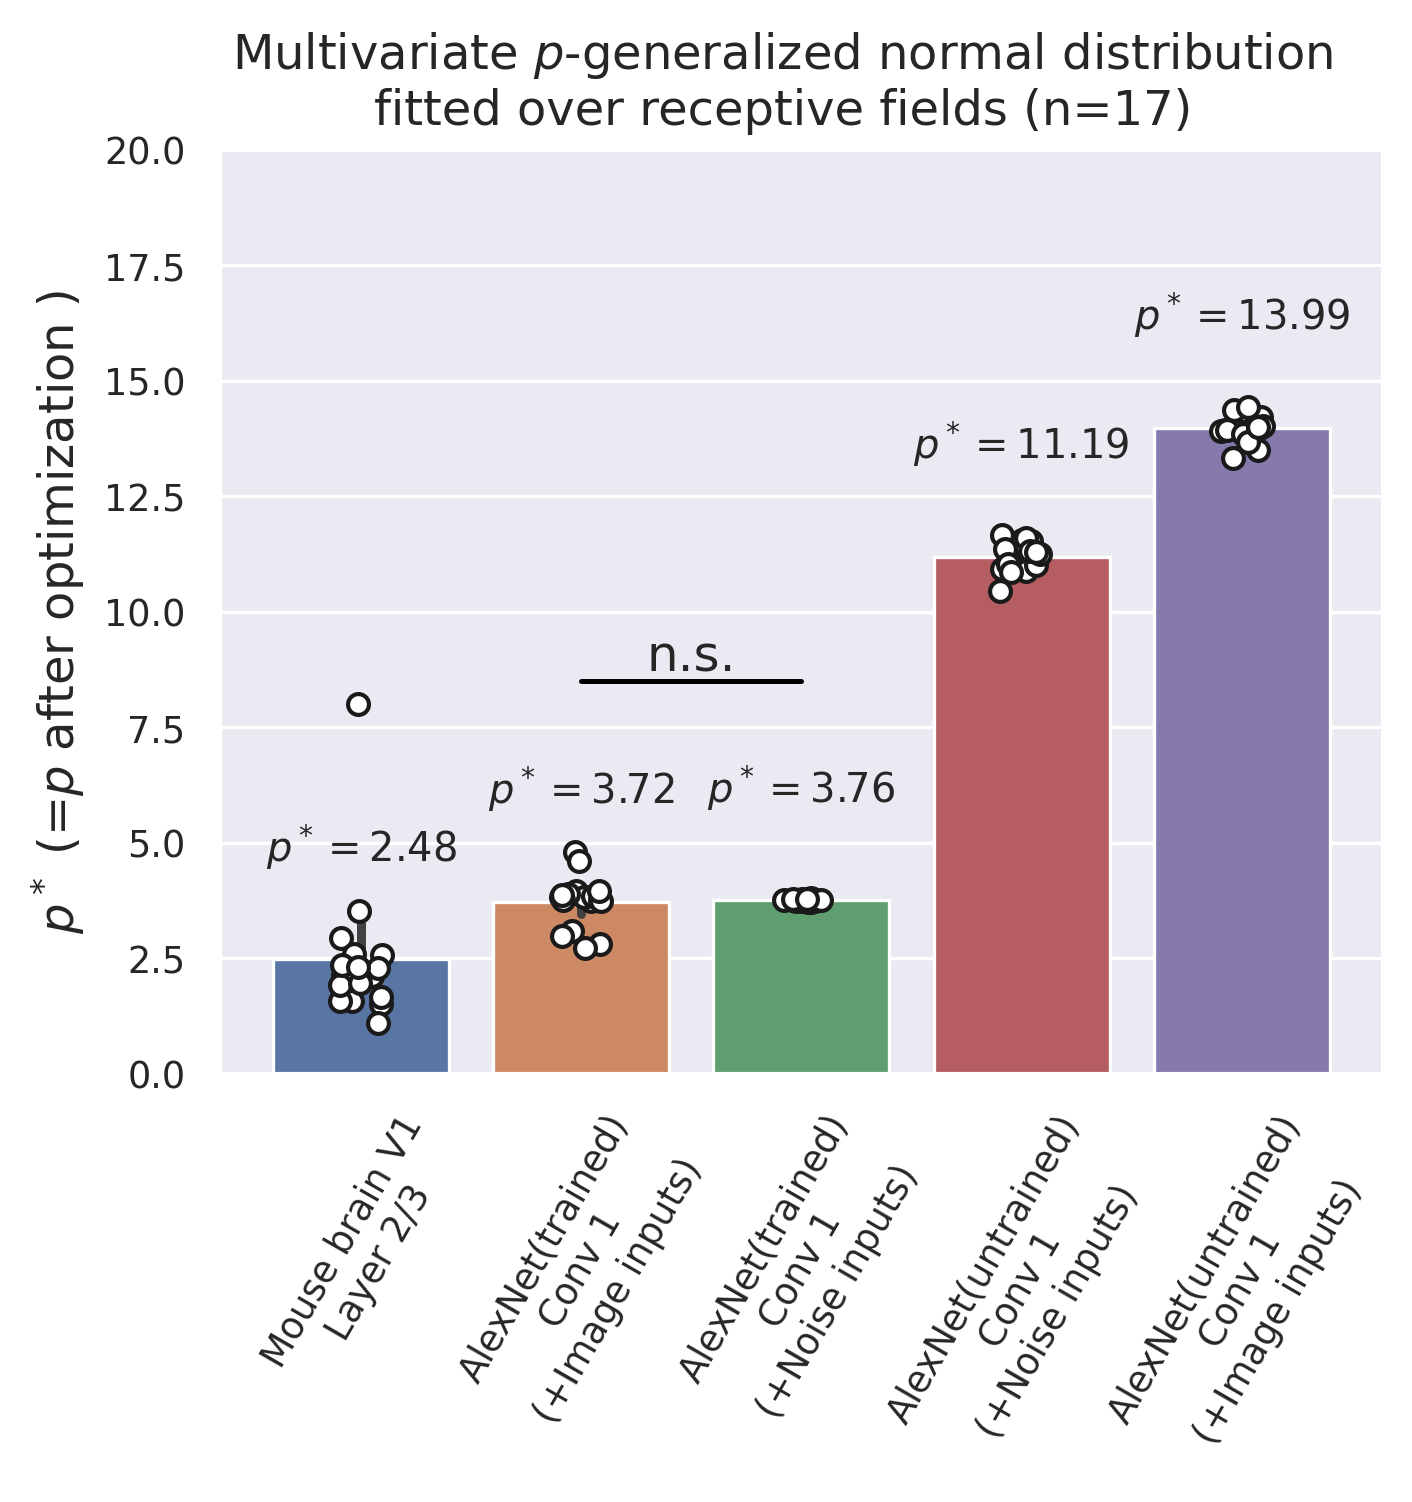

In [367]:
sns.set('paper')
fig, ax = plt.subplots(1, 1, figsize=(5,4), dpi=300)
g = sns.stripplot(data=df, x='name', y='p', color='w', edgecolor='k', linewidth=1, ax=ax)
g = sns.barplot(data=df, x='name', y='p', ax=ax)
ax.set_xticklabels(ax.get_xticklabels(), rotation=60, horizontalalignment='center')
ax.set_xlabel('')
ax.set_ylabel(r'$p^*$ (=$p$ after optimization )', fontsize='large')
ax.set_ylim(0, 20)
for p in ax.patches:
    ax.annotate(r'$p^*=$'+f'{p.get_height():.2f}\n',
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='bottom',
                xytext=(0, 10),
                textcoords='offset points')

ax.plot([1, 2], [8.5, 8.5], color='black')
ax.text(1.5, 8.5, 'n.s.', ha='center', va='bottom', fontsize=12)

plt.suptitle(r'Multivariate $p$-generalized normal distribution''\nfitted over receptive fields (n=17)')
fig.savefig('/content/drive/MyDrive/lpconv/artificial_biological_rfs/summary_barplot_optimized_p.png', bbox_inches='tight')

<ipython-input-349-f90cbebbed9b>:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  grouped_dfs = df.groupby(['name','key']).mean().sort_values(by='p')


Mouse
AlexNet(trained)
AlexNet(trained)
AlexNet(untrained)
AlexNet(untrained)


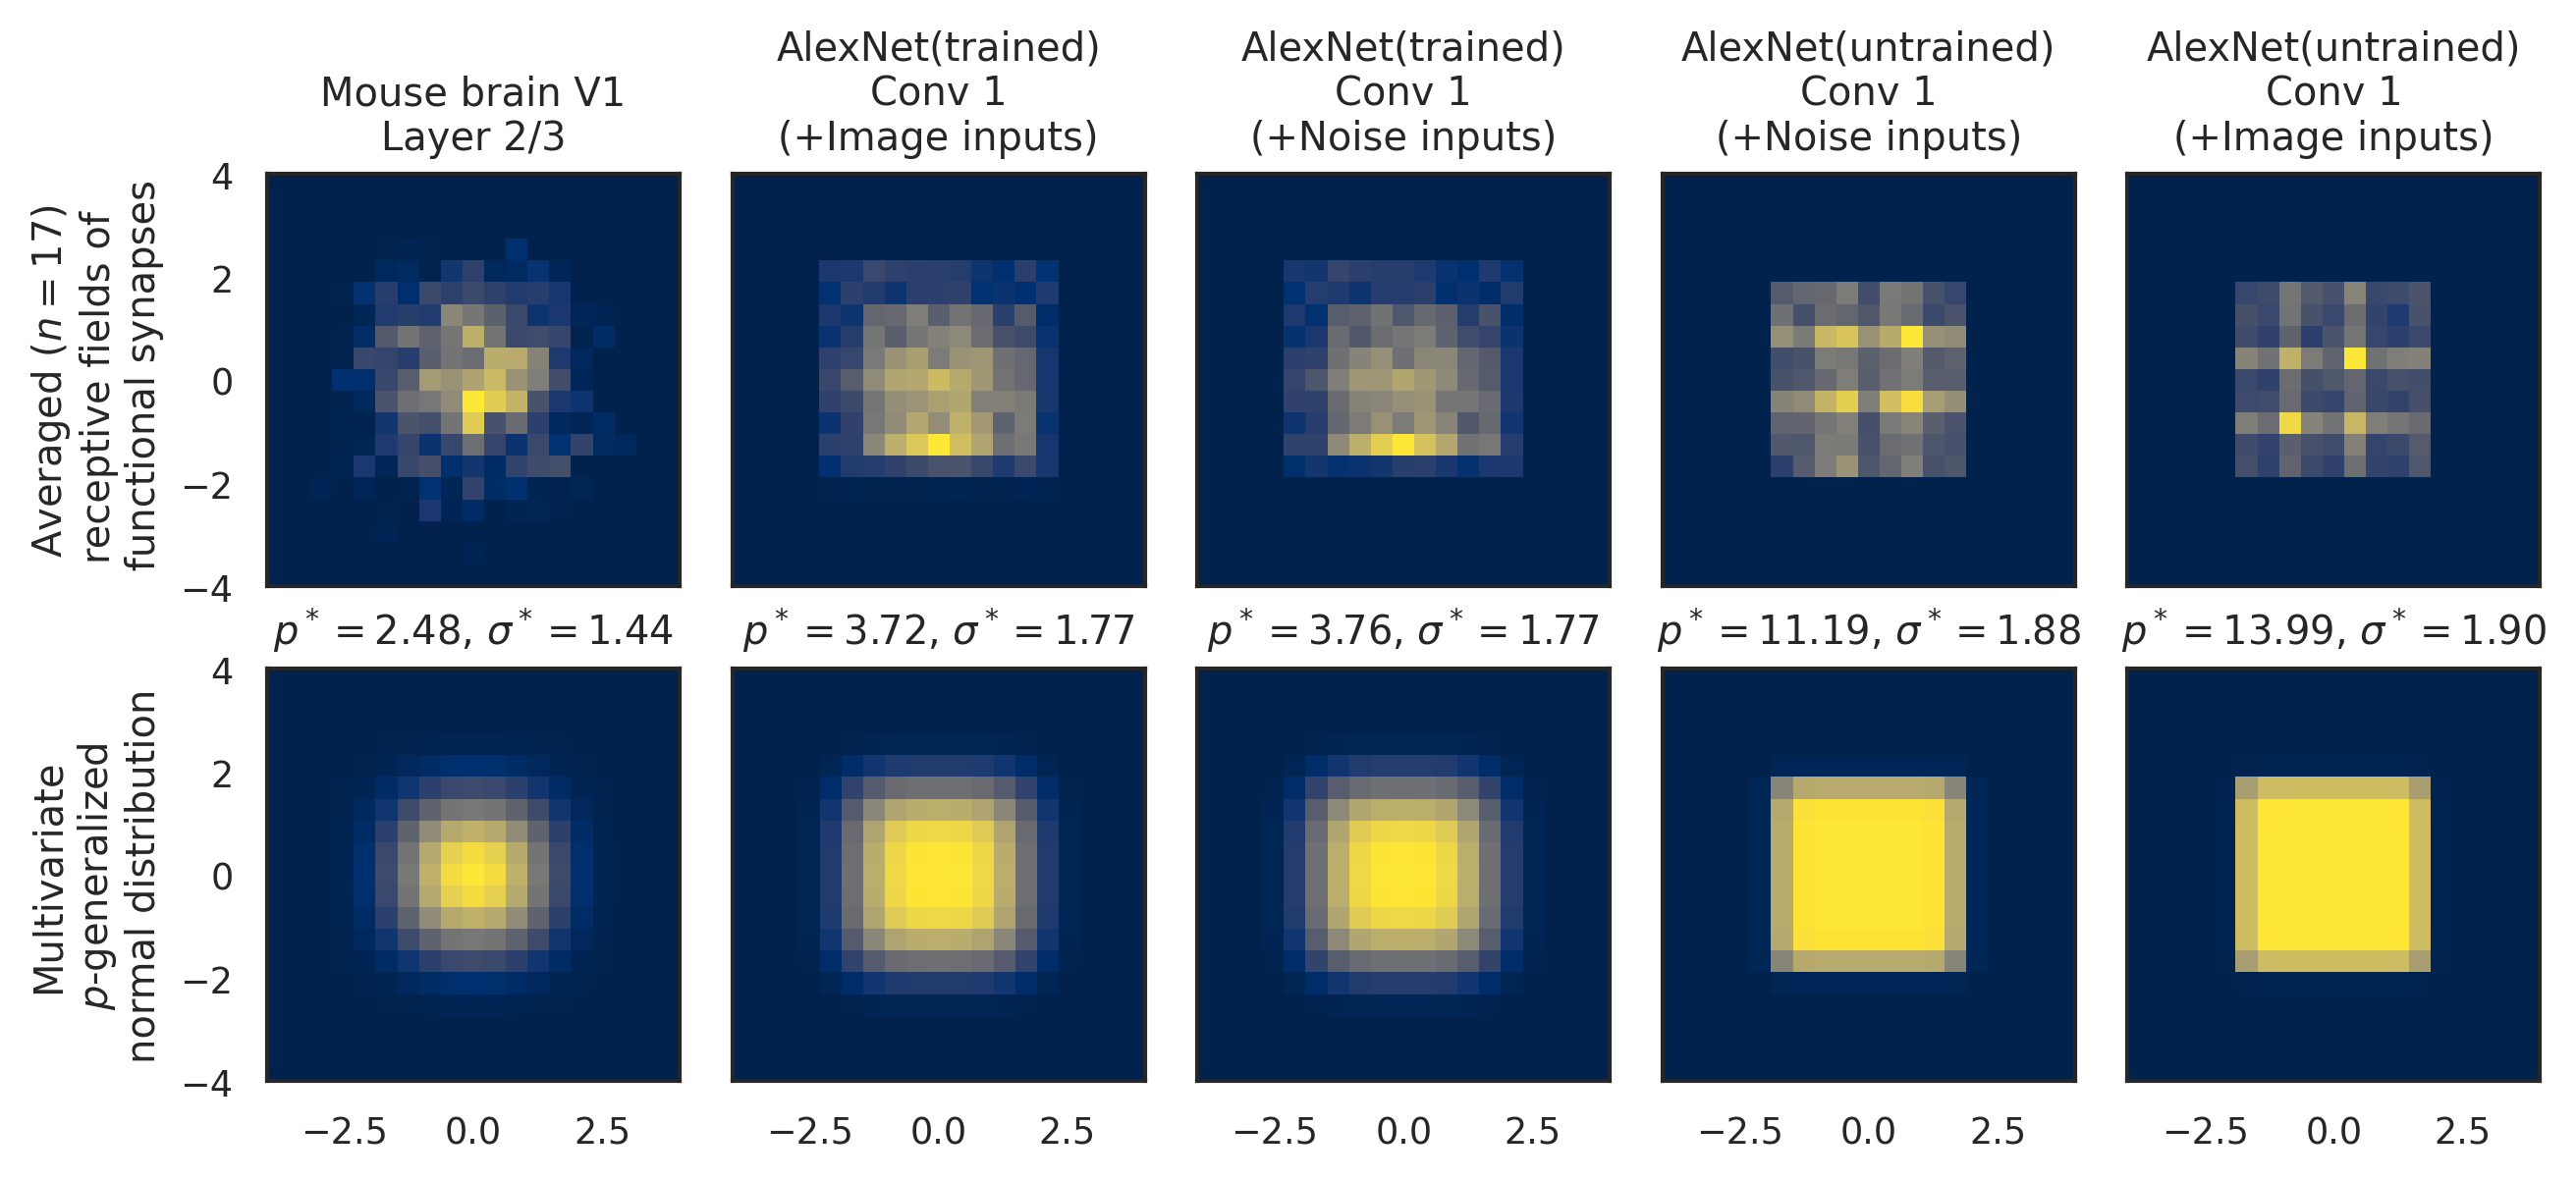

In [349]:
sns.set_style('white')

x = (xedges[:-1]+xedges[1:])/2
y = (yedges[:-1]+yedges[1:])/2
offset = np.stack( np.meshgrid(x, y) )

fig, axes = plt.subplots(2, 5, figsize=(10, 4), sharex=True, sharey=True, dpi=300)
grouped_dfs = df.groupby(['name','key']).mean().sort_values(by='p')
fig.subplots_adjust(wspace=0.1, hspace=0.2)
for i, idx in enumerate(grouped_dfs.index):
    p = grouped_dfs.loc[idx]['p']
    sigma = grouped_dfs.loc[idx]['sigma']

    mu = np.array([0, 0])
    C = np.array([[1/sigma, 0], [0, 1/sigma]])

    # get real RFs
    Z = RFs[idx[1]].mean(axis=0)

    # get lp-optimized RFs
    Z_ = Phi(offset.reshape(2, -1), mu, C, p=p).reshape(offset.shape[-2:])
    Z_ = Z_/Z_.sum()
    print(idx[0].split()[0])
    axes[0, i].set_title(idx[0])
    axes[0, i].imshow(Z,  extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]], cmap='cividis')
    axes[1, i].set_title(r'$p^*=$'+f'{p:.2f}, '+r'$\sigma^*=$'+f'{sigma:.2f}')
    axes[1, i].imshow(Z_, extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]], cmap='cividis')
axes[0, 0].set_ylabel(r'Averaged $(n=17)$' '\nreceptive fields of \n functional synapses')
axes[1, 0].set_ylabel('Multivariate\n' + r'$p$-generalized'+'\nnormal distribution')

fig.savefig('/content/drive/MyDrive/lpconv/artificial_biological_rfs/MeanRFs_LpRFs.png', bbox_inches='tight')